# Laboratorio 2 - Series de tiempo
## Consumo de combustible

##### Sebastian Aristondo 20880
##### Daniel Gonzalez 20293

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 1. Análisis expolatorio

### 1.1 Consumo de combustibles

In [167]:
consumo = pd.read_csv('consumo.csv', sep=',')
consumo.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Kerosina,Mezclas oleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total
0,Jan/2000,0.00,"48,446.00","296,766.99",0.0,0.00,0.00,0.00,"194,410.48","1,426.00",...,"64,026.09",0.00,0.0,0.00,0.00,0.00,0.0,"634,667.06",0.00,"1,750,544.64"
1,Feb/2000,0.00,"50,597.00","328,116.44",0.0,0.00,0.00,0.00,"174,710.55","1,458.00",...,"62,660.30",0.00,0.0,0.00,0.00,0.00,0.0,"642,380.66",0.00,"1,773,220.22"
2,Mar/2000,0.00,"27,593.00","368,589.63",0.0,0.00,0.00,0.00,"189,234.07","1,503.00",...,"61,361.99",0.00,0.0,0.00,0.00,0.00,0.0,"699,807.25",0.00,"1,909,498.79"
3,Apr/2000,0.00,"53,794.00","396,300.47",0.0,0.00,0.00,0.00,"174,330.61","1,561.00",...,"61,814.32",0.00,0.0,0.00,0.00,0.00,0.0,"586,803.98",0.00,"1,800,932.86"
4,May/2000,0.00,"60,137.00","449,368.92",0.0,0.00,0.00,0.00,"191,745.15","1,642.00",...,"54,098.32",0.00,0.0,0.00,0.00,0.00,0.0,"656,948.20",0.00,"1,941,771.90"


In [168]:
columns_to_convert = [col for col in consumo.columns if col != 'Fecha']
consumo[columns_to_convert] = consumo[columns_to_convert].apply(lambda x: x.str.replace(',', '').astype(float) if x.dtype == 'object' else x)\

consumo.describe()

,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,Gasolina regular,...,Kerosina,Mezclas oleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total
count,281.000000,281.000000,281.000000,280.000000,281.000000,2.810000e+02,281.000000,281.000000,281.000000,281.000000,...,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,2.810000e+02,281.000000,2.810000e+02
mean,4291.018078,28320.540961,306899.841210,-1.695929,35953.793274,2.603631e+05,2303.973381,303105.399893,1223.807224,367626.393559,...,19774.585089,212.063772,15.754626,123875.779786,53618.566263,1807.681779,10.289893,5.925927e+05,14228.544484,2.573688e+06
std,9060.350581,15061.399091,149027.263795,120.930501,23392.884977,4.804376e+05,4363.660816,101787.584005,353.009681,192320.697474,...,21811.283087,613.181249,57.585737,114615.582775,32948.218215,3934.695321,23.760251,3.478895e+05,45343.764687,6.235583e+05
min,0.000000,2287.930000,33606.200000,-841.640000,0.000000,0.000000e+00,0.000000,167818.140000,0.000000,160741.900000,...,-4603.490000,0.000000,-22.460000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.673279e+06
25%,0.000000,17687.890000,162734.650000,0.000000,18507.790000,0.000000e+00,0.000000,225593.820000,1003.000000,213645.390000,...,758.660000,0.000000,0.000000,69055.690000,35207.320000,0.000000,0.000000,5.578026e+05,0.000000,2.114746e+06
50%,0.000000,25774.420000,304037.550000,0.000000,39135.650000,0.000000e+00,0.000000,256040.100000,1224.040000,275031.210000,...,10620.700000,0.000000,0.000000,96222.500000,45686.000000,0.000000,0.000000,6.998072e+05,0.000000,2.394185e+06
75%,0.000000,35584.540000,406269.280000,0.000000,50690.500000,0.000000e+00,0.000000,373503.780000,1458.000000,502041.670000,...,31964.770000,0.000000,0.000000,142986.060000,70523.000000,0.000000,0.000000,8.076921e+05,0.000000,2.928755e+06
max,31025.180000,77035.870000,697861.800000,919.240000,94150.680000,1.463008e+06,16475.250000,588892.160000,2734.000000,875010.340000,...,70821.940000,3134.830000,525.040000,748589.980000,137937.120000,16166.190000,89.720000,1.216423e+06,184302.000000,4.473316e+06


In [169]:
consumo['Fecha'] = pd.to_datetime(consumo['Fecha'], format='%b/%Y')
consumo.dtypes

Fecha                       datetime64[ns]
Aceites lubricantes                float64
Asfalto                            float64
Bunker                             float64
Ceras                              float64
Combustible turbo jet              float64
Diesel bajo azufre                 float64
Diesel ultra bajo azufre           float64
Gas licuado de petróleo            float64
Gasolina de aviación               float64
Gasolina regular                   float64
Gasolina superior                  float64
Grasas lubricantes                 float64
Kerosina                           float64
Mezclas oleosas                    float64
Naftas                             float64
PetCoke                            float64
Petróleo crudo                     float64
Solventes                          float64
Butano                             float64
Diesel alto azufre                 float64
Orimulsión                         float64
Total                              float64
dtype: obje

In [170]:
consumo["Diesel_conjunto"] = consumo["Diesel alto azufre"] + consumo["Diesel bajo azufre"]
consumo["Diesel_conjunto"] = consumo["Diesel_conjunto"].fillna(0)
consumo["Diesel_conjunto"] = consumo["Diesel_conjunto"].astype(float)
consumo.dropna(subset=["Diesel_conjunto"], inplace=True)

nans_por_columna = consumo.isna().sum()

print("Valores NaN por columna:")
print(nans_por_columna)

Valores NaN por columna:
Fecha                       0
Aceites lubricantes         0
Asfalto                     0
Bunker                      0
Ceras                       1
Combustible turbo jet       0
Diesel bajo azufre          0
Diesel ultra bajo azufre    0
Gas licuado de petróleo     0
Gasolina de aviación        0
Gasolina regular            0
Gasolina superior           0
Grasas lubricantes          0
Kerosina                    0
Mezclas oleosas             0
Naftas                      0
PetCoke                     0
Petróleo crudo              0
Solventes                   0
Butano                      0
Diesel alto azufre          0
Orimulsión                  0
Total                       0
Diesel_conjunto             0
dtype: int64


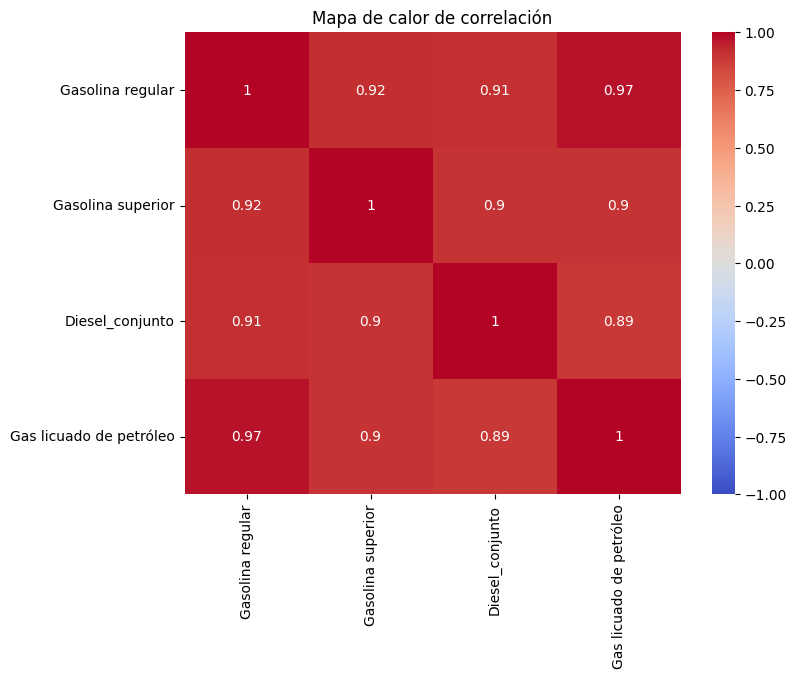

In [171]:
columnas_interes = ["Gasolina regular", "Gasolina superior", "Diesel_conjunto", "Gas licuado de petróleo"]
consumo_numericas = consumo[columnas_interes]

correlation_matrix = consumo_numericas.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de calor de correlación')
plt.show()

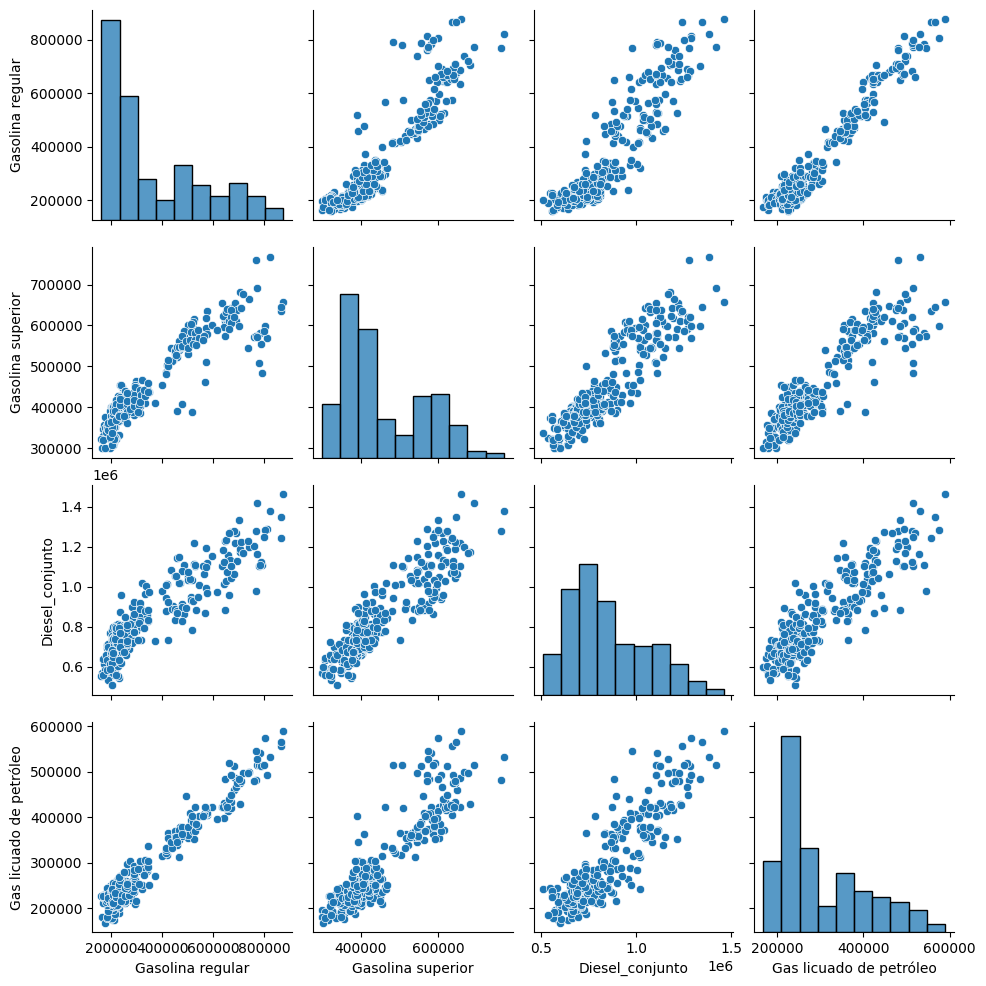

In [172]:
grid = sns.pairplot(consumo_numericas)
plt.show()

In [173]:
normality_test = consumo_numericas.apply(normaltest)
print("Resultados de test de normalidad: \n", normality_test)

Resultados de test de normalidad: 
    Gasolina regular  Gasolina superior  Diesel_conjunto  \
0      3.507221e+01       2.957783e+01        21.627472   
1      2.421952e-08       3.777945e-07         0.000020   

   Gas licuado de petróleo  
0             3.069400e+01  
1             2.162134e-07  


Ninguna de las distribuciones de las variables interesantes es normal.

In [174]:
consumo["Mes"] = consumo["Fecha"].dt.month
consumo["Año"] = consumo["Fecha"].dt.year

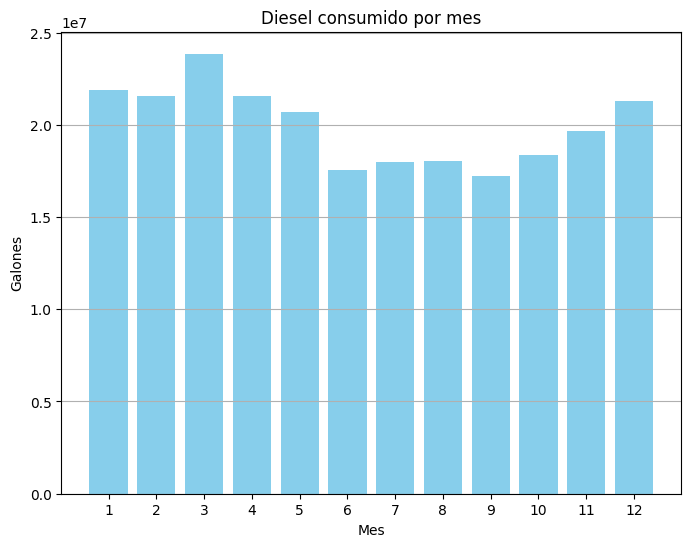

In [175]:
suma_por_mes = consumo.groupby('Mes')['Diesel_conjunto'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Diesel consumido por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

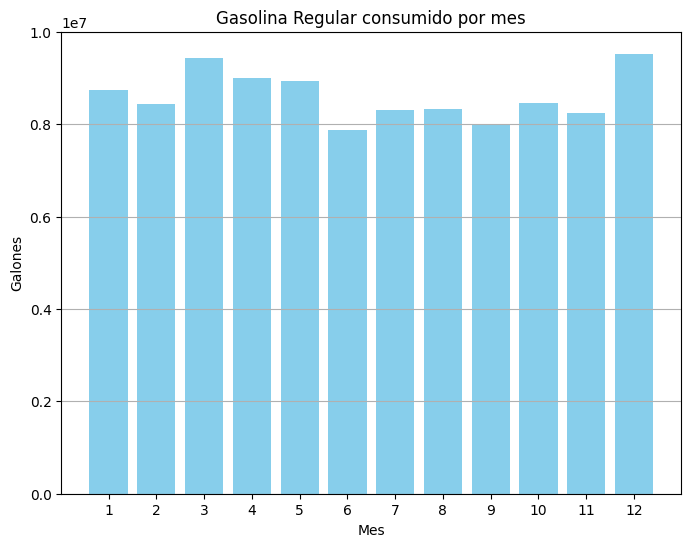

In [176]:
suma_por_mes = consumo.groupby('Mes')['Gasolina regular'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina Regular consumido por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

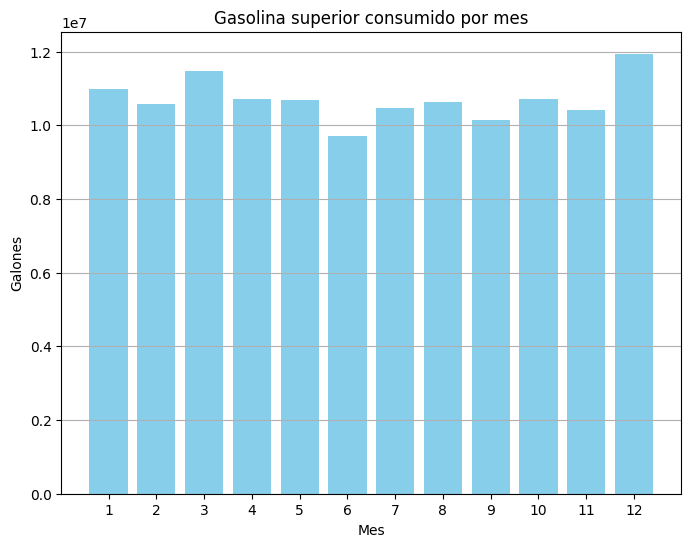

In [177]:
suma_por_mes = consumo.groupby('Mes')['Gasolina superior'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina superior consumido por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

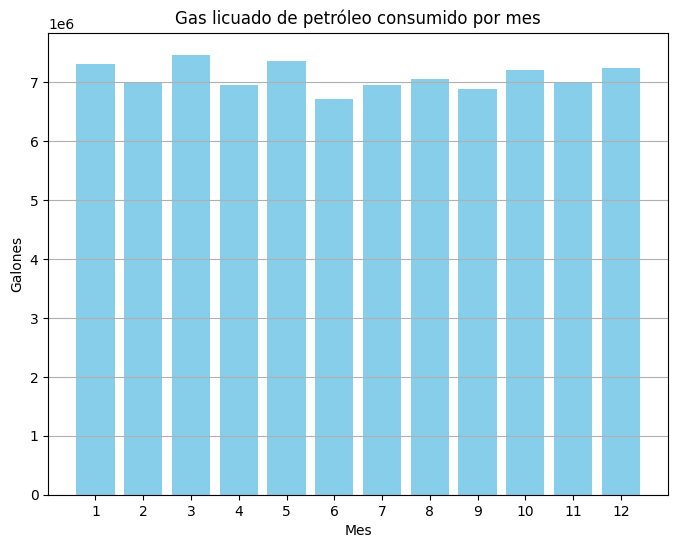

In [178]:
suma_por_mes = consumo.groupby('Mes')['Gas licuado de petróleo'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gas licuado de petróleo consumido por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

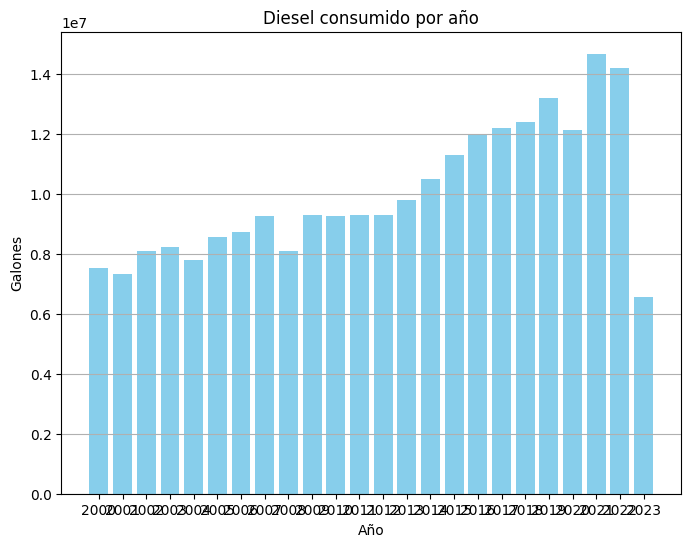

In [179]:
suma_por_mes = consumo.groupby('Año')['Diesel_conjunto'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Diesel consumido por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

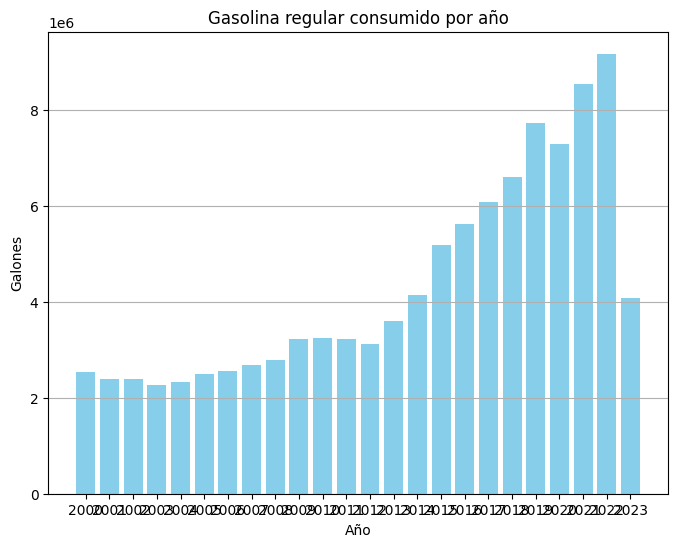

In [180]:
suma_por_mes = consumo.groupby('Año')['Gasolina regular'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gasolina regular consumido por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

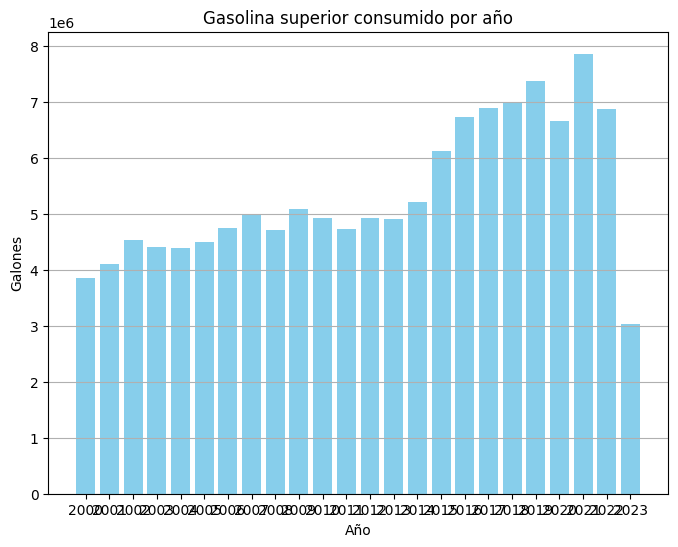

In [181]:
suma_por_mes = consumo.groupby('Año')['Gasolina superior'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gasolina superior consumido por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

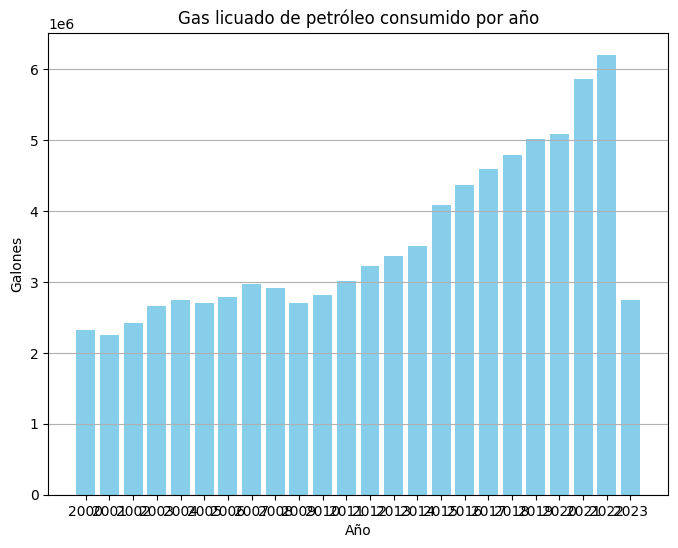

In [182]:
suma_por_mes = consumo.groupby('Año')['Gas licuado de petróleo'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gas licuado de petróleo consumido por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

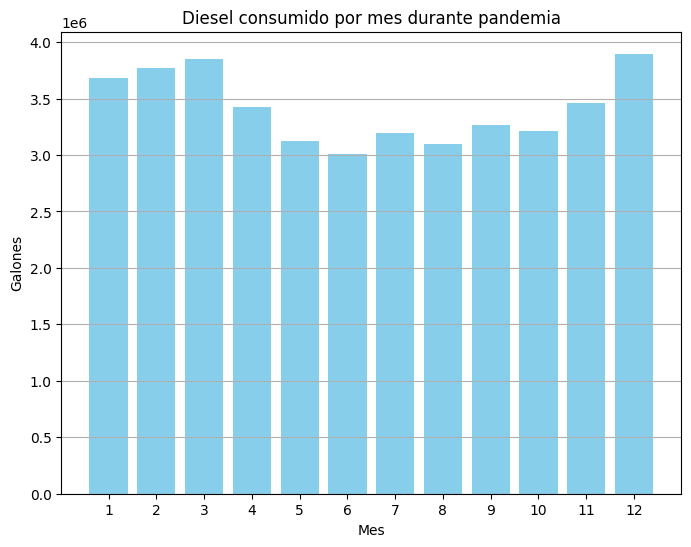

In [183]:
datos_pandemia = consumo[(consumo["Fecha"].dt.year >= 2020) & (consumo["Fecha"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Diesel_conjunto'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Diesel consumido por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

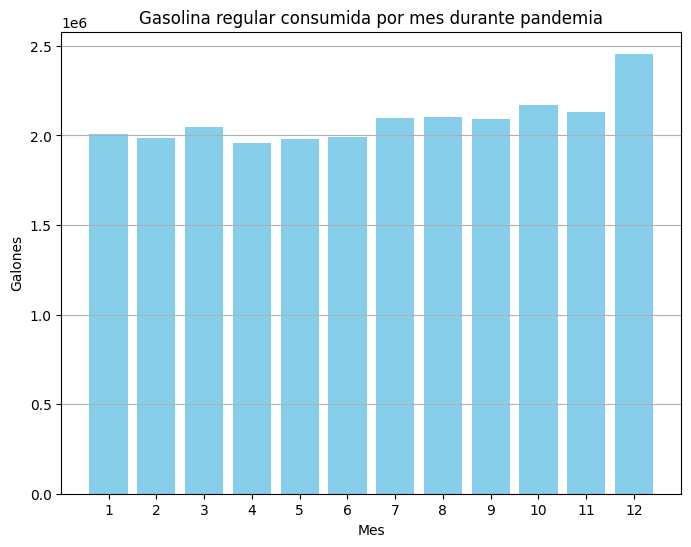

In [184]:
suma_por_mes = datos_pandemia.groupby('Mes')['Gasolina regular'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina regular consumida por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

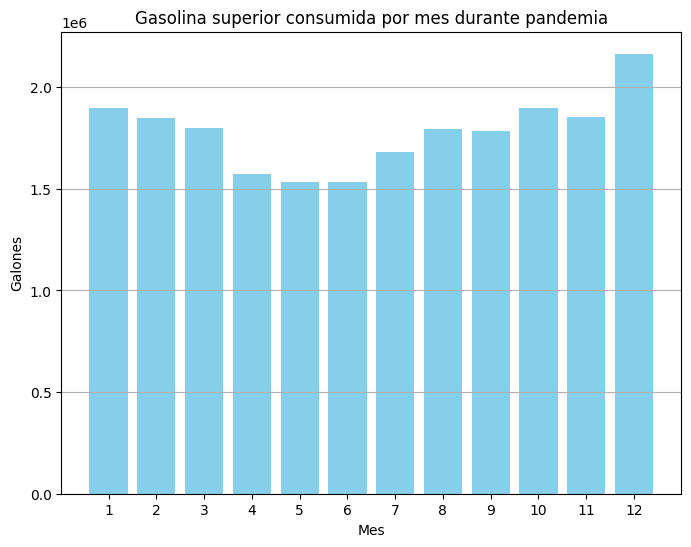

In [185]:
datos_pandemia = consumo[(consumo["Fecha"].dt.year >= 2020) & (consumo["Fecha"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Gasolina superior'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina superior consumida por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

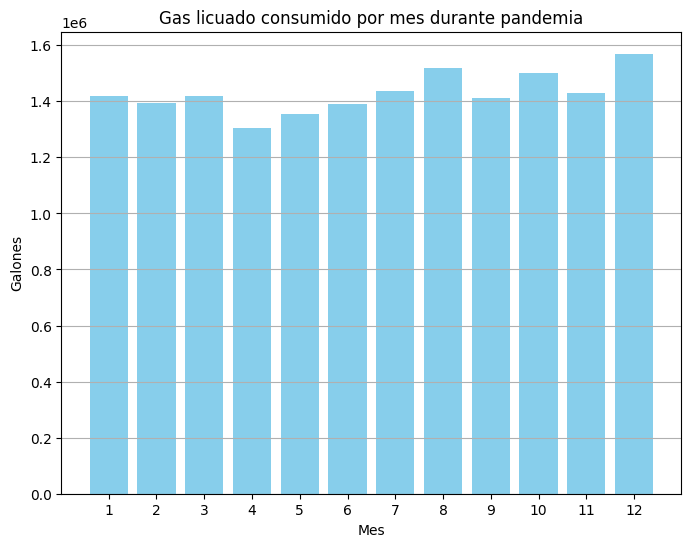

In [186]:
datos_pandemia = consumo[(consumo["Fecha"].dt.year >= 2020) & (consumo["Fecha"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Gas licuado de petróleo'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gas licuado consumido por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

### 1.2 Importación de combustibles

### 1.3 Precio en Ciudad Capital

## 2. Elección de series de tiempo

* Serie 1: Consumo de diesel
* Serie 2: Importacion de gasolina regular
* Serie 3: Precio de gasolina super

## 3. Análisis de series de tiempo - Consumo de diesel

#### a. Especifique Inicio, fin, y frecuencia.

In [187]:
print("Inicio de frecuencia: ", min(consumo["Fecha"]))
print("Fin de frecuencia: ", max(consumo["Fecha"]))
print("La frecuencia es mensual")

Inicio de frecuencia:  2000-01-01 00:00:00
Fin de frecuencia:  2023-05-01 00:00:00
La frecuencia es mensual


#### b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

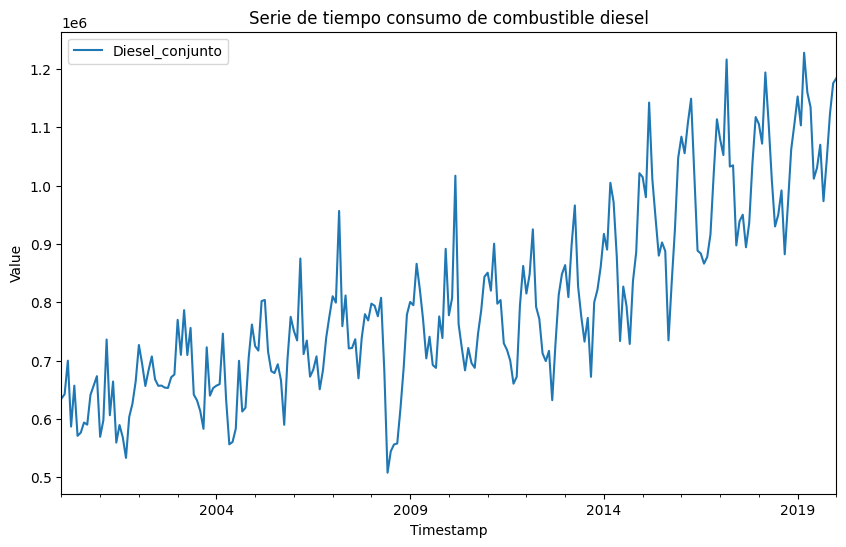

In [210]:
consumo_diesel = consumo[["Fecha", "Diesel_conjunto"]].copy()
consumo_diesel["Fecha"] = pd.to_datetime(consumo_diesel["Fecha"])
consumo_diesel.set_index("Fecha", inplace=True)

consumo_diesel_train = consumo_diesel[consumo_diesel.index <= "2020-01-01"].copy()
consumo_diesel_test = consumo_diesel[consumo_diesel.index >= "2020-01-01"].copy()


# consumo_diesel_train = consumo_diesel_train[consumo_diesel_train["Fecha"].dt.year >= 2020]
# consumo_diesel_train["Fecha"] = pd.to_datetime(consumo_diesel_train["Fecha"])
# consumo_diesel_train.set_index("Fecha" , inplace=True)

# consumo_diesel_test["Fecha"] = pd.to_datetime(consumo_diesel_test["Fecha"])
# consumo_diesel_test.set_index("Fecha", inplace=True)

consumo_diesel_train.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo consumo de combustible diesel')
plt.show()

A primera vista se puede observar que existe una tendencia a la alza en la serie de tiempo de consumo de combustible. Se puede observar una caída cerca de 2009.

#### c. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

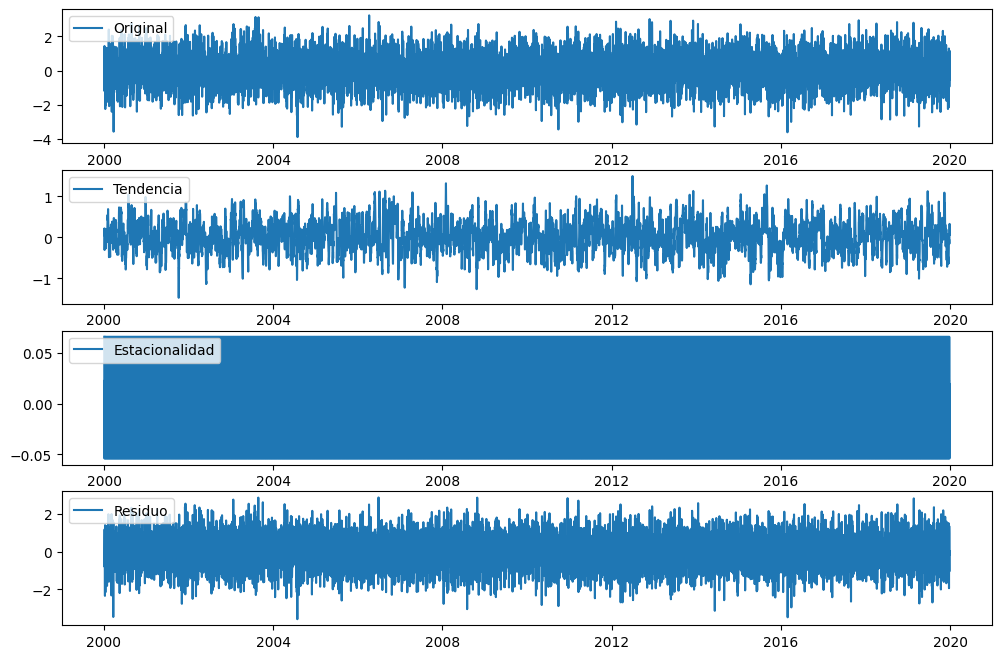

In [189]:
# Crear un índice de fechas para la serie temporal (puedes omitir esta parte si ya tienes un DataFrame con fechas como índice)
date_rng = pd.date_range(start=min(consumo_diesel_train.index), end=max(consumo_diesel_train.index), freq='D')
values = np.random.randn(len(date_rng))  # Valores aleatorios para el ejemplo

# Crear el DataFrame con la serie temporal
ts_df = pd.DataFrame(values, index=date_rng, columns=['Value'])

# Realizar la descomposición
result = seasonal_decompose(ts_df['Value'], model='additive', period=7)  # Puedes cambiar 'additive' a 'multiplicative' según la naturaleza de la estacionalidad

# Visualizar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(ts_df['Value'], label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuo')
plt.legend(loc='upper left')
plt.show()

Al graficar la serie de tiempo para el consumo de diesel en Guatemala, se puede observar que existe una tendencia a la alza. Esto puede indicar que no existe estacionariedad en media. También se observa que la varianza no es constante, por lo que igualmente es posible que no exista estacionariedad en varianza. No se puede observar por la cantidad de datos, pero es posible que exista estacionalidad. Se realizará la prueba de Dickey Fuller para confirmar si existe estacionariedad en media.

#### d. Determine si es necesario transformar la serie. Explique.

Se aplicará boxcox a la serie para poder hacerla estacionaria en varianza. Como se mencionó, se puede observar en la serie de tiempo diferencias entre las varianzas.

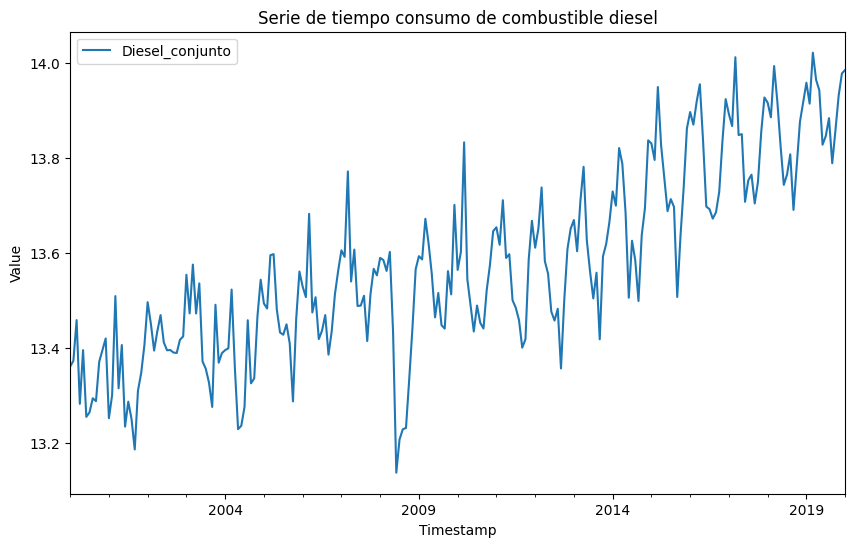

In [190]:
# transformed_values, lambda_value = boxcox(consumo_diesel_train['Diesel_conjunto'])
transformed_values = np.log(consumo_diesel_train['Diesel_conjunto'])
consumo_diesel_train['Diesel_conjunto'] = transformed_values
consumo_diesel_train.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo consumo de combustible diesel')
plt.show()


#### d. Explique si no es estacionaria en media. Para esto:

##### i. Haga el gráfico de autocorrelación y úselo para explicar la no estacionariedad en media.

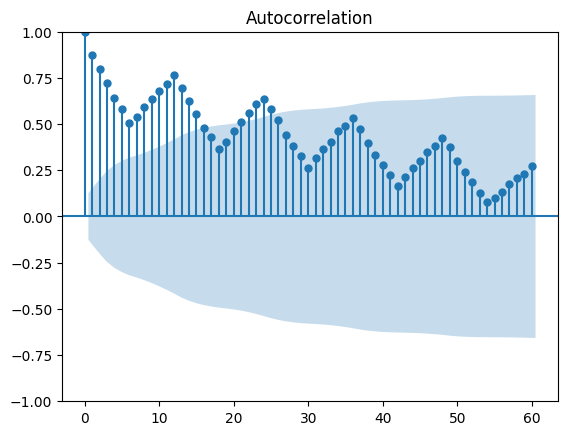

In [191]:
fig = plot_acf(consumo_diesel_train['Diesel_conjunto'], lags=60)
plt.show()

Se puede observar que los valores de la autocorrelación no decrecen rápidamente a 0. Esto indica que el proceso no es estacionario, porque existe una tendencia en la media. Se evidencia que hay cierta periodicidad en los datos, por lo que se puede concluir que el proceso no es estacionario.

##### ii. Básese en los valores de estadísticos como la prueba de Dickey-Fuller Aumentada para corroborar la no estacionariedad en media. ¿Qué es necesario hacer para hacerla estacionaria en media en caso de que no lo sea?

In [192]:
def check_stationarity(timeseries):
    # Realizar la prueba ADF
    resultado_adf = adfuller(consumo_diesel_train)

    # Extraer los resultados importantes de la prueba
    adf_stat = resultado_adf[0]
    p_valor = resultado_adf[1]
    valores_criticos = resultado_adf[4]

    # Imprimir los resultados
    print("Estadístico ADF:", adf_stat)
    print("P-valor:", p_valor)
    print("Valores críticos:")
    for key, value in valores_criticos.items():
        print(f"  {key}: {value}")
check_stationarity(consumo_diesel_train)

Estadístico ADF: -0.24401882939185274
P-valor: 0.9330672289232065
Valores críticos:
  1%: -3.4593607492757554
  5%: -2.8743015807562924
  10%: -2.5735714042782396


Por medio de ADF se puede observar que la serie no es estacionaria, al tener un p-value de 0.89, entonces no se puede rechazar la hipótesis nula, por lo que se procede a diferenciarla.

In [193]:
consumo_diesel_train = consumo_diesel_train.diff().dropna()
check_stationarity(consumo_diesel_train)

Estadístico ADF: -6.569942137338175
P-valor: 7.982718720029744e-09
Valores críticos:
  1%: -3.4593607492757554
  5%: -2.8743015807562924
  10%: -2.5735714042782396


Una vez se realizó una diferenciación, se volvió a realizar el test ADF y se logró determinar que ahora la serie de tiempo es estacionaria, al obtener un valor menor a la significancia.

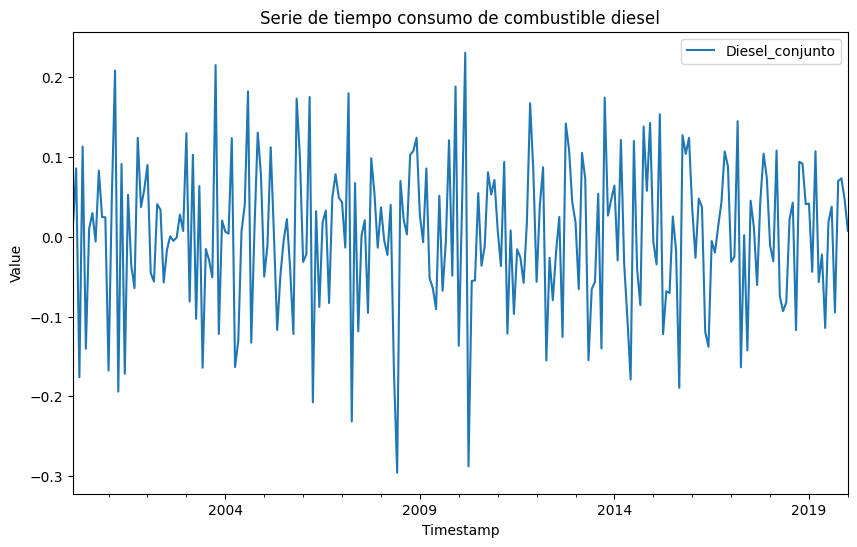

In [194]:
consumo_diesel_train.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo consumo de combustible diesel')
plt.show()

En el gráfico no se puede observar una tendencia, si no que parece ser que la media es constante.

#### f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA que utilizará para predecir. Explique en qué se basó para darle valor a estos parámetros, basándose en las funciones de autocorrelación y autocorrelación parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el modelo propuesto.

### Autocorrelación parcial

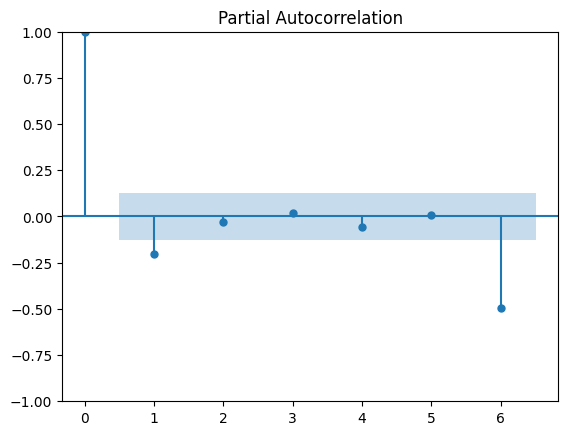

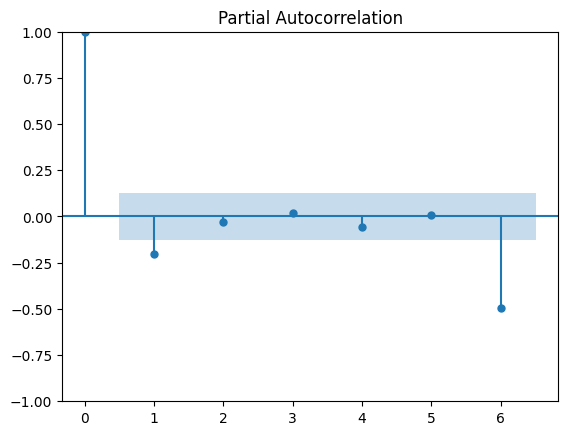

In [195]:
plot_pacf(consumo_diesel_train, lags=6)

### Autocorrelación

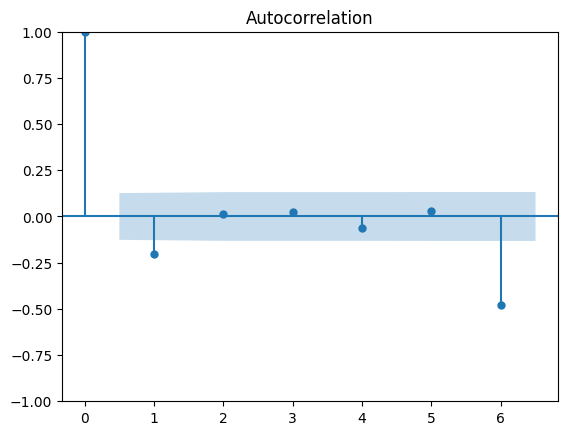

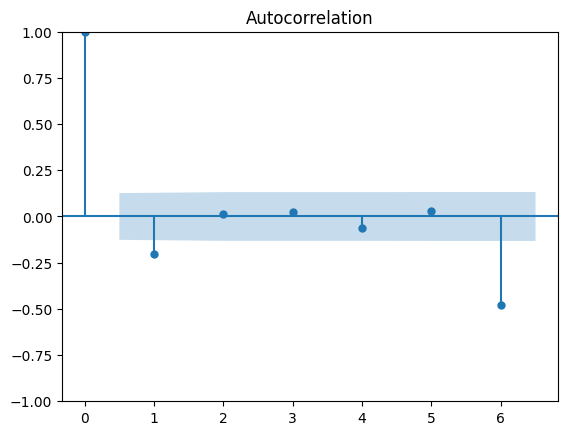

In [196]:
plot_acf(consumo_diesel_train, lags=6)

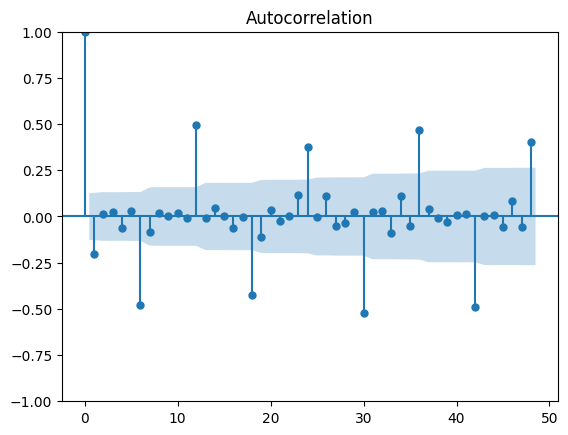

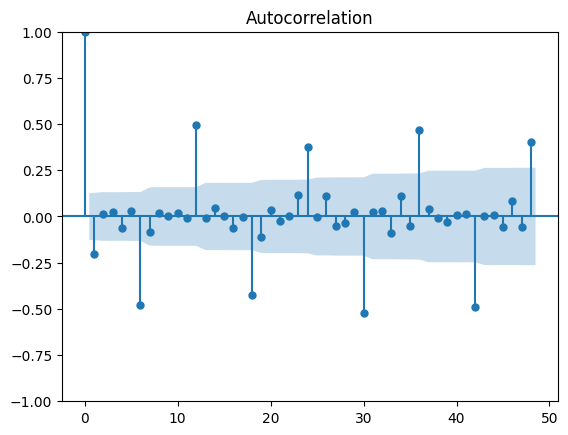

In [197]:
plot_acf(consumo_diesel_train, lags=48)

Se puede observar un comportamiento similar cada 12 meses, lo cual indica que hay estacionalidad por esta correlación entre los meses.

Se crearán dos modelos de ARIMA con parámetros: 
* p = 1, d = 1, q = 2
* p = 2, d = 1, q = 2

Además, de los gráficos se probarán los parámetros para estacionalidad se probarán los parámetros:
* p = 1, d = 1, q = 0

In [198]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

modelo1 = SARIMAX(consumo_diesel_train, order=(1,1,2), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m1 = modelo1.fit()
print(resultado_m1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0118      0.105      0.112      0.910      -0.194       0.217
ma.L1         -1.6209     77.972     -0.021      0.983    -154.444     151.202
ma.L2          0.6209     48.420      0.013      0.990     -94.280      95.521
ar.S.L12      -0.4662      0.053     -8.757      0.000      -0.571      -0.362
sigma2         0.0053      0.411      0.013      0.990      -0.801       0.811


In [199]:
modelo2 = SARIMAX(consumo_diesel_train, order=(2,1,2), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m2 = modelo2.fit()
print(resultado_m2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1023      0.138     -0.740      0.459      -0.373       0.168
ar.L2         -0.1071      0.084     -1.269      0.205      -0.273       0.058
ma.L1         -1.4853    257.690     -0.006      0.995    -506.549     503.578
ma.L2          0.4853    125.072      0.004      0.997    -244.651     245.621
ar.S.L12      -0.4574      0.053     -8.646      0.000      -0.561      -0.354
sigma2         0.0050      1.297      0.004      0.997      -2.536       2.546


### g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie. Para esto analice los residuos y las métricas AIC y/ BIC.
Los modelos se habían hecho previamente.

#### Modelo 1

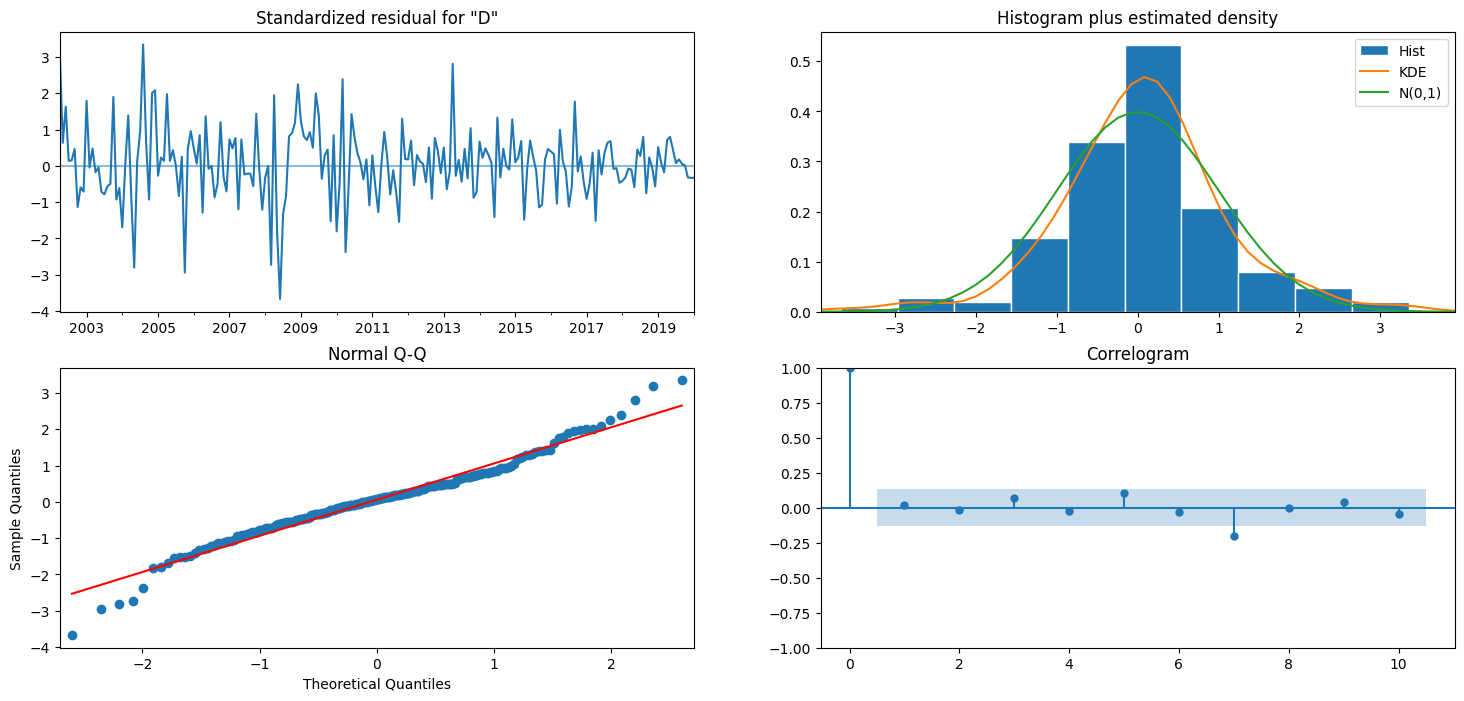

In [200]:
resultado_m1.plot_diagnostics(figsize=(18, 8))
plt.show()

#### Modelo 2

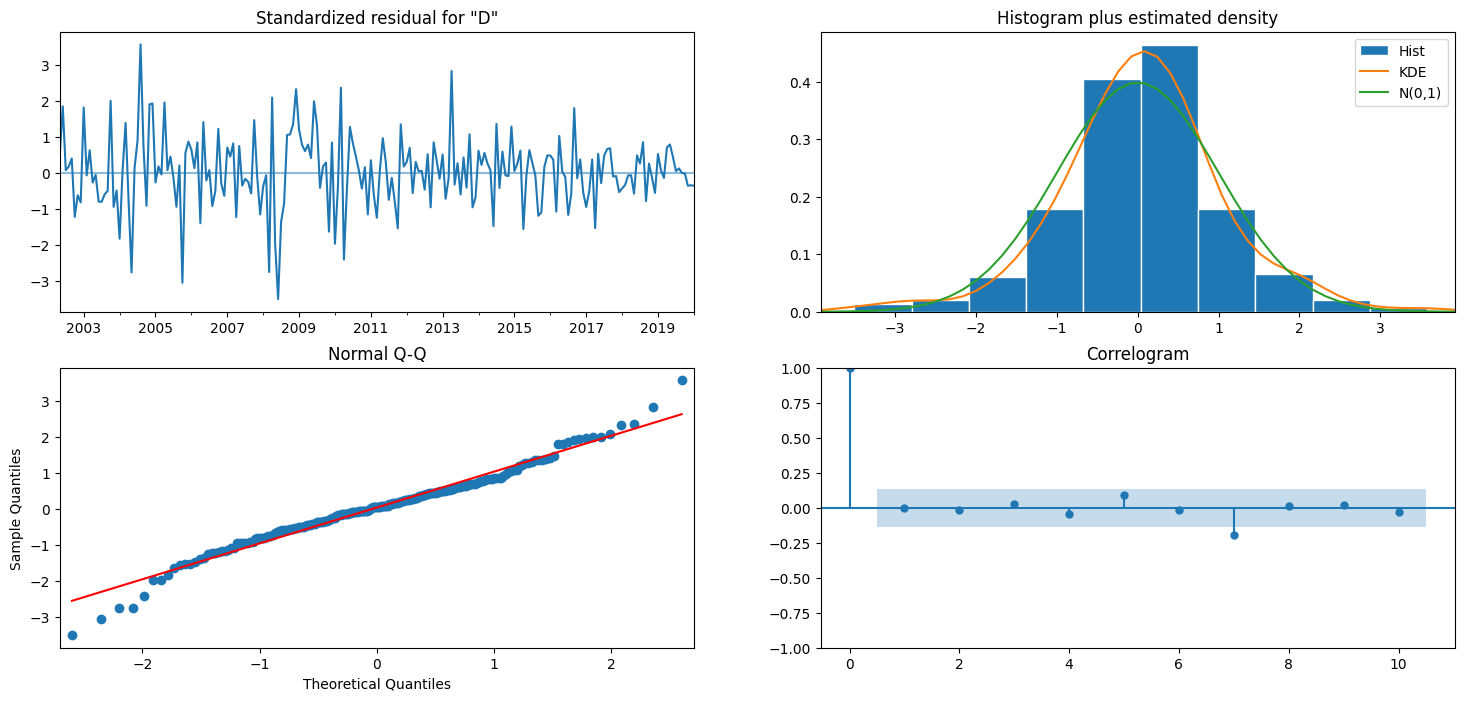

In [201]:
resultado_m2.plot_diagnostics(figsize=(18, 8))
plt.show()

Al observar el análisis de residuales de ambos modelos se puede evidenciar que es posible que los residuales solo sean ruido blanco. Se ve una distribución normal, a excepción por unos puntos atípicos en las colas. Además, no se ve correlación entre los puntos, al ver el correlograma.

In [202]:
print("AIC para modelo 1:", resultado_m1.aic)
print("BIC para modelo 1:", resultado_m1.bic)
print("\nAIC para modelo 2:", resultado_m2.aic)
print("BIC para modelo 2:", resultado_m2.bic)

AIC para modelo 1: -498.70739914016247
BIC para modelo 1: -481.8775190650532

AIC para modelo 2: -505.42346587008547
BIC para modelo 2: -485.2557128758289


Se puede observar que ambos modelos tienen residuales muy similares. Además, al comparar el AIC y el BIC de ambos modelos, ambos son bastante similares. El primero modelo, que usa p = 1, d = 1, q = 2, tiene un AIC un poco más alto que el segundo modelo, igual en BIC. Entonces es posible decir que el segundo modelo, con p = 2, d = 1 y q = 2, es mejor.
En general, para ambos modelos el AIC y BIC son bastante bajos, por lo tanto parece ser que son dos modelos que se adaptan bien a los datos

#### h. Haga un modelo usando el algoritmo de redes neuronales. Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

In [110]:
# En esta ocasion solo usaremos train y test, validation lo omitiremos para simpleza del ejercicio
# NO CAMBIEN NADA DE ESTA CELDA POR FAVOR
p_train=0.8
p_test=0.2

datos = consumo_diesel_train[['Diesel_conjunto']].values.astype('float32')

# Definimos el tamaño de las particiones
num_train = int(len(datos)*p_train)
num_test = int(len(datos)*p_test)


# Dividir las secuencias en las particiones
train = datos[:num_train]
test = datos[num_train:]

In [111]:
import torch

def create_timeseries_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

# EL VALOR DE LB SÍ LO PUEDEN CAMBIAR SI LO CONSIDERAN NECESARIO
lb = 5
X_train, y_train = create_timeseries_dataset(train, lookback=lb)
#X_validation, y_validation = create_timeseries_dataset(validation, lookback=lb)
X_test, y_test = create_timeseries_dataset(test, lookback=lb)

print(X_train.shape, y_train.shape)
#print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

torch.Size([187, 5, 1]) torch.Size([187, 5, 1])
torch.Size([43, 5, 1]) torch.Size([43, 5, 1])


In [112]:
import torch.nn as nn

class CustomModelLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1 , hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        # YOUR CODE HERE
        x, _ = self.lstm(x)
        x = self.linear(x)
        # raise NotImplementedError()
        return x

In [113]:
import torch.optim as optim
import torch.utils.data as data
import random
seed_ = 1234
# NOTEN QUE ESTOY PONIENDO DE NUEVO LOS SEEDS PARA SER CONSTANTES
random.seed(seed_)
np.random.seed(seed_)
 
model = CustomModelLSTM()
# Optimizador y perdida
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# Observen como podemos también definir un DataLoader de forma snecilla
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
 
# Pueden cambiar el número de epocas en esta ocasión con tal de llegar al valor de la metrica de desempeño
n_epochs = 3010

# Perdidas
loss_train = []
loss_test = []

# Iteramos sobre cada epoca
for epoch in range(n_epochs):
    # Colocamos el modelo en modo de entrenamiento
    model.train()
    
    # Cargamos los batches
    for X_batch, y_batch in loader:
        # Obtenemos una primera prediccion
        y_pred = model(X_batch)
        # Calculamos la perdida
        loss = loss_fn(y_pred, y_batch)
        # Reseteamos la gradiente a cero
        #   sino la gradiente de previas iteraciones se acumulará con las nuevas
        optimizer.zero_grad()
        # Backprop
        loss.backward()
        # Aplicar las gradientes para actualizar los parametros del modelo
        optimizer.step()
        
    # Validación cada 100 epocas
    if epoch % 100 != 0 and epoch != n_epochs-1:
        continue
    # Colocamos el modelo en modo de evaluación
    model.eval()
    
    # Deshabilitamos el calculo de gradientes
    with torch.no_grad():
        # Prediccion
        y_pred = model(X_train)
        # Calculo del RMSE - Root Mean Square Error
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # Prediccion sobre validation
        y_pred = model(X_test)
        # Calculo del RMSE para validation
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        loss_train.append(train_rmse)
        loss_test.append(test_rmse)
        
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0975, test RMSE 0.0782
Epoch 100: train RMSE 0.0946, test RMSE 0.0787
Epoch 200: train RMSE 0.0939, test RMSE 0.0786
Epoch 300: train RMSE 0.0926, test RMSE 0.0780
Epoch 400: train RMSE 0.0909, test RMSE 0.0762
Epoch 500: train RMSE 0.0897, test RMSE 0.0740
Epoch 600: train RMSE 0.0882, test RMSE 0.0724
Epoch 700: train RMSE 0.0861, test RMSE 0.0720
Epoch 800: train RMSE 0.0837, test RMSE 0.0729
Epoch 900: train RMSE 0.0820, test RMSE 0.0742
Epoch 1000: train RMSE 0.0806, test RMSE 0.0756
Epoch 1100: train RMSE 0.0790, test RMSE 0.0766
Epoch 1200: train RMSE 0.0772, test RMSE 0.0784
Epoch 1300: train RMSE 0.0758, test RMSE 0.0797
Epoch 1400: train RMSE 0.0744, test RMSE 0.0802
Epoch 1500: train RMSE 0.0733, test RMSE 0.0812
Epoch 1600: train RMSE 0.0721, test RMSE 0.0825
Epoch 1700: train RMSE 0.0736, test RMSE 0.0880
Epoch 1800: train RMSE 0.0701, test RMSE 0.0855
Epoch 1900: train RMSE 0.0701, test RMSE 0.0861
Epoch 2000: train RMSE 0.0679, test RMSE 0.0863
Epoc

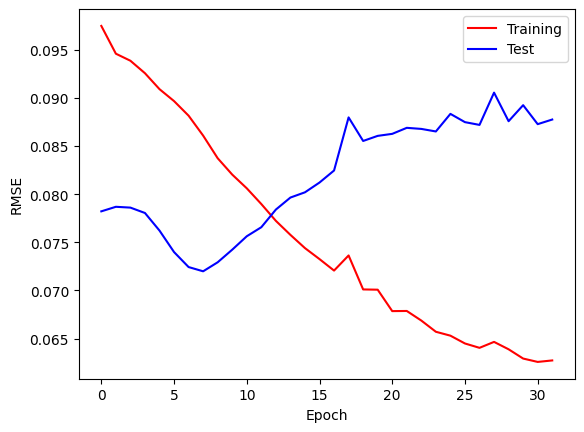

In [114]:
# Visualización del rendimiento
epoch = np.arange(len(loss_train))
plt.figure()
plt.plot(epoch, loss_train, 'r', label='Training',)
plt.plot(epoch, loss_test, 'b', label='Test')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

Se puede observar que la pérdida para train y test es muy diferente, por lo tanto es un mal modelo.

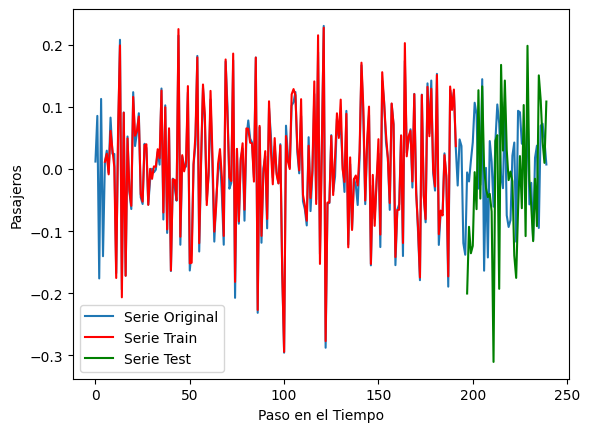

In [115]:
# Graficamos
with torch.no_grad():
    # Movemos las predicciones de train para graficar
    train_plot = np.ones_like(datos) * np.nan
    # Prediccion de train
    y_pred = model(X_train)
    # Extraemos los datos solo del ultimo paso
    y_pred = y_pred[:, -1, :]
    train_plot[lb : num_train] = model(X_train)[:, -1, :]
    # Movemos las predicciones de test
    test_plot = np.ones_like(datos) * np.nan
    test_plot[num_train + lb : len(datos)] = model(X_test)[:, -1, :]
    
plt.figure()
plt.plot(datos, label="Serie Original")
plt.plot(train_plot, c='r', label="Serie Train")
plt.plot(test_plot, c='g', label="Serie Test")
plt.xlabel('Paso en el Tiempo'), plt.ylabel('Pasajeros')
plt.legend()
plt.show()

In [116]:
y_pred = model(X_test)
residuals = y_pred - y_test
# Calculate log-likelihood of residuals
log_likelihood = -0.5 * torch.sum(torch.log(2 * np.pi * torch.var(residuals)) + (residuals ** 2) / torch.var(residuals))

# Calculate the number of parameters in your model
num_params = sum(p.numel() for p in model.parameters())

# Calculate the number of samples
num_samples = len(y_pred)

# Calculate AIC and BIC
AIC = 2 * num_params - 2 * log_likelihood
BIC = num_params * np.log(num_samples) - 2 * log_likelihood

print("AIC:", AIC)
print("BIC:", BIC)

AIC: tensor(20865.9004, grad_fn=<RsubBackward1>)
BIC: tensor(39624.4453, grad_fn=<RsubBackward1>)


Se puede observar que al usar LSTM para realizar la predicción de serie de tiempo, el AIC y BIC tiene valores demasiado altos, de 20906.99 y 39665.53 respectivamente. Por lo tanto, no es un buen modelo para realizar la predicción del dataset.

## 4. Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan buena es su predicción. En el caso de la serie de precios, use los datos de 2023 como conjunto de prueba

2020-02-01    0.976995
2020-03-01    1.113304
2020-04-01    0.936760
2020-05-01    0.945939
2020-06-01    0.905167
2020-07-01    1.019723
2020-08-01    1.040559
2020-09-01    0.899936
2020-10-01    1.084041
2020-11-01    1.084803
2020-12-01    1.044322
2021-01-01    1.023269
2021-02-01    0.967369
2021-03-01    1.112872
2021-04-01    0.940216
2021-05-01    0.960531
2021-06-01    0.898737
2021-07-01    1.018844
2021-08-01    1.039273
2021-09-01    0.904156
2021-10-01    1.078226
2021-11-01    1.080319
2021-12-01    1.045394
2022-01-01    1.015578
2022-02-01    0.971596
2022-03-01    1.112789
2022-04-01    0.938364
2022-05-01    0.953457
2022-06-01    0.901498
2022-07-01    1.018993
2022-08-01    1.039607
2022-09-01    0.901956
2022-10-01    1.080656
2022-11-01    1.082130
2022-12-01    1.044627
2023-01-01    1.018896
2023-02-01    0.969375
2023-03-01    1.112543
2023-04-01    0.938987
2023-05-01    0.956504
2023-06-01    0.899980
Freq: MS, Name: predicted_mean, dtype: float64


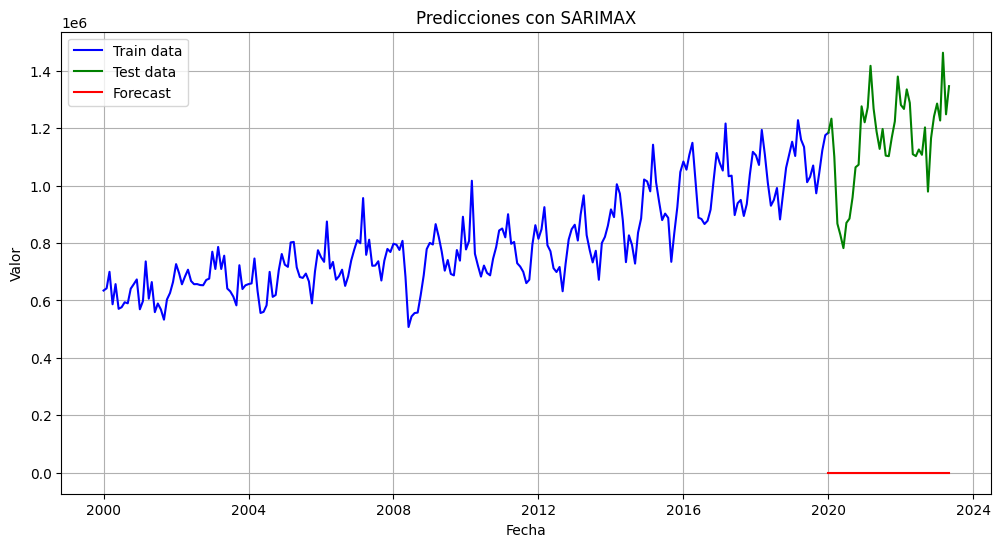

In [246]:
forecast = resultado_m1.get_forecast(steps=len(consumo_diesel_test))

# Los resultados incluirán las predicciones, intervalos de confianza y otros detalles útiles:
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Invertir la transformación logarítmica.
forecast_values_original_scale = np.exp(forecast_values)
# print(forecast_values_original_scale)

# Si también aplicaste una diferenciación, debes invertirla también.
d = 1  # Reemplaza esto con el valor de diferenciación utilizado en el modelo SARIMAX.
# forecast_values_original_scale = consumo_diesel.iloc[-d:] + np.cumsum(forecast_values_original_scale)
print(forecast_values_original_scale)

# # Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(consumo_diesel_train.index, consumo_diesel_train['Diesel_conjunto'], label='Train data', color='blue')
plt.plot(consumo_diesel_test.index, consumo_diesel_test['Diesel_conjunto'], label='Test data', color='green')
plt.plot(consumo_diesel_test.index, forecast_values_original_scale, label='Forecast', color='red')

# Rellenar el área entre los intervalos de confianza superior e inferior.
plt.fill_between(consumo_diesel_test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones con SARIMAX')
plt.legend()
plt.grid(True)
plt.show()